# Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

# Load data

In [2]:
data_dir = "../data/220930/"
data_file = "220930_1um-beads.csv"
traj_df = pd.read_csv(os.path.join(data_dir, data_file))
traj_df.head()
# traj_df = traj_df[traj_df.t < 1100]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,y_drift,x_drift,t,centrosome_0_x,centrosome_0_y
0,478.975668,223.204606,216078.161731,1.767735,0.299407,16539.784310,731847.0,0.004186,0,1,0.0,0.0,1.217144,348.366568,330.751522
1,478.350172,115.929770,109323.228630,1.597403,0.281948,10915.499117,359610.0,0.008635,0,2,0.0,0.0,1.217144,348.366568,330.751522
2,477.635509,85.782777,77007.535867,1.852046,0.173566,5278.571803,305985.0,0.010195,0,3,0.0,0.0,1.217144,348.366568,330.751522
3,477.412929,334.399692,128182.355930,1.602829,0.094250,12206.940413,766032.0,0.003997,0,4,0.0,0.0,1.217144,348.366568,330.751522
4,477.218709,277.316754,97445.469601,1.767798,0.136971,7675.226227,362683.0,0.008560,0,5,0.0,0.0,1.217144,348.366568,330.751522


# Catogorize beads

In [3]:
n_centrosomes = int(
    len([col for col in traj_df.columns if col.startswith("centrosome")]) / 2
)

for i in range(n_centrosomes):
    traj_df["distance_to_centrosome_%d" % i] = np.sqrt(
        (traj_df.y - traj_df["centrosome_%d_y" % i]) ** 2
        + (traj_df.x - traj_df["centrosome_%d_x" % i]) ** 2
    )

traj_df["centrosome"] = 0 if n_centrosomes == 1 else -1
total_replacement_group = []
for particle in tqdm(traj_df.particle.unique()):
    particle_df = traj_df[traj_df.particle == particle].copy()
    if n_centrosomes > 1:
        centrosome = np.argmin(
            [
                particle_df["distance_to_centrosome_%d" % i].max()
                for i in range(n_centrosomes)
            ]
        )
        traj_df.loc[traj_df.particle == particle, "centrosome"] = centrosome
    else:
        centrosome = 0
    total_replacement_group.append(
        particle_df.loc[particle_df.index[0], "distance_to_centrosome_%d" % centrosome]
        - particle_df.loc[
            particle_df.index[-1], "distance_to_centrosome_%d" % centrosome
        ]
    )

if n_centrosomes > 1:
    for cen in range(n_centrosomes):
        print(
            f"Centrosome {cen}: {traj_df[traj_df.centrosome == cen].particle.nunique()}"
        )

traj_df.head()

  0%|          | 0/1406 [00:00<?, ?it/s]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,y_drift,x_drift,t,centrosome_0_x,centrosome_0_y,distance_to_centrosome_0,centrosome
0,478.975668,223.204606,216078.161731,1.767735,0.299407,16539.784310,731847.0,0.004186,0,1,0.0,0.0,1.217144,348.366568,330.751522,193.999778,0
1,478.350172,115.929770,109323.228630,1.597403,0.281948,10915.499117,359610.0,0.008635,0,2,0.0,0.0,1.217144,348.366568,330.751522,275.340201,0
2,477.635509,85.782777,77007.535867,1.852046,0.173566,5278.571803,305985.0,0.010195,0,3,0.0,0.0,1.217144,348.366568,330.751522,300.873981,0
3,477.412929,334.399692,128182.355930,1.602829,0.094250,12206.940413,766032.0,0.003997,0,4,0.0,0.0,1.217144,348.366568,330.751522,147.324953,0
4,477.218709,277.316754,97445.469601,1.767798,0.136971,7675.226227,362683.0,0.008560,0,5,0.0,0.0,1.217144,348.366568,330.751522,162.790395,0


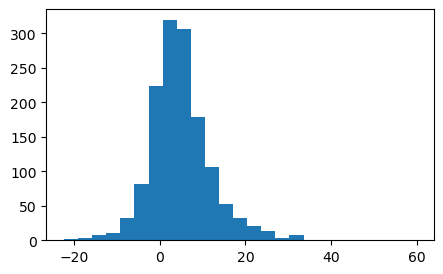

In [4]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(total_replacement_group, bins=25);

In [5]:
traj_df["active"] = traj_df.total_replacement.apply(lambda x: x > 3)

AttributeError: 'DataFrame' object has no attribute 'total_replacement'

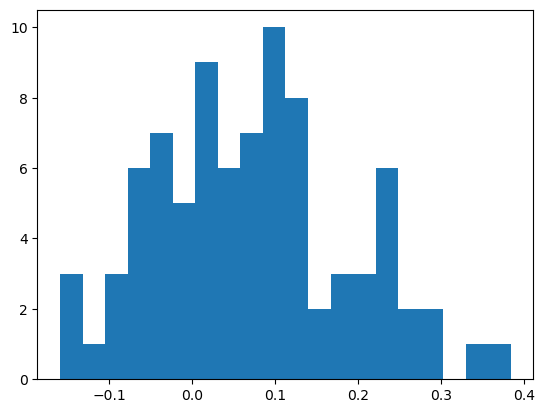

In [21]:
particle_df = traj_df[traj_df.particle == 13].copy()
plt.hist(np.diff(particle_df.distance_to_centrosome_0), bins=20);

  0%|          | 0/1098 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (s)')

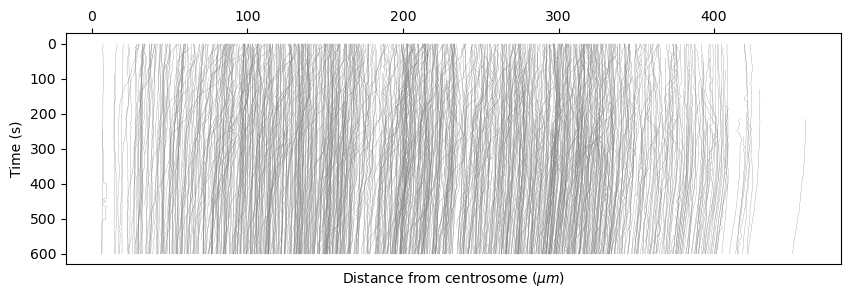

In [10]:
_, ax = plt.subplots(1, 1, figsize=(10, 3))
cen = 0
for particle in tqdm(
    traj_df[(traj_df.centrosome == cen) & (traj_df.active)].particle.unique()
):
    particle_df = traj_df[traj_df.particle == particle].copy()
    ax.plot(
        particle_df["distance_to_centrosome_%d" % cen],
        particle_df.t,
        lw=0.2,
        color="gray",
    )
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xlabel("Distance from centrosome ($\mu m$)")
ax.set_ylabel("Time (s)")

  0%|          | 0/1098 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (s)')

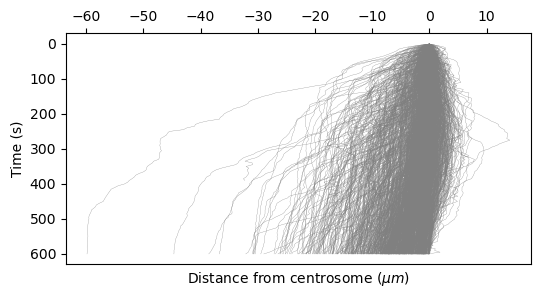

In [44]:
_, ax = plt.subplots(1, 1, figsize=(6, 3))
cen = 0
for particle in tqdm(
    traj_df[(traj_df.centrosome == cen) & (traj_df.active)].particle.unique()
):
    particle_df = traj_df[traj_df.particle == particle].copy()
    ax.plot(
        particle_df["distance_to_centrosome_%d" % cen] - particle_df.loc[particle_df.index[0], "distance_to_centrosome_%d"%cen],
        particle_df.t,
        lw=0.2,
        color="gray",
    )
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xlabel("Distance from centrosome ($\mu m$)")
ax.set_ylabel("Time (s)")

# Velocity vs. distance to centrosome

In [31]:
cen = 0
dist_v_df = pd.DataFrame()
i = 0
v_matrix = np.nan * np.ones((traj_df.particle.nunique(), traj_df.frame.nunique() - 1))
for particle in tqdm(
    traj_df[(traj_df.centrosome == cen) & (traj_df.active)].particle.unique()
):
    particle_df = traj_df[traj_df.particle == particle].copy()
    v = - np.diff(particle_df["distance_to_centrosome_%d" % cen]) / np.diff(
        particle_df.t
    )
    v_matrix[i, :len(v)] = v
    dist_v_df.loc[i, "vmax"] = v[np.argpartition(v, -5)[-5:]].mean()
    distances = particle_df["distance_to_centrosome_%d" % cen].values[:-1]
    dist_v_df.loc[i, "distance"] = distances[np.argpartition(v, -5)[-5:]].mean()
    i += 1

  0%|          | 0/1098 [00:00<?, ?it/s]

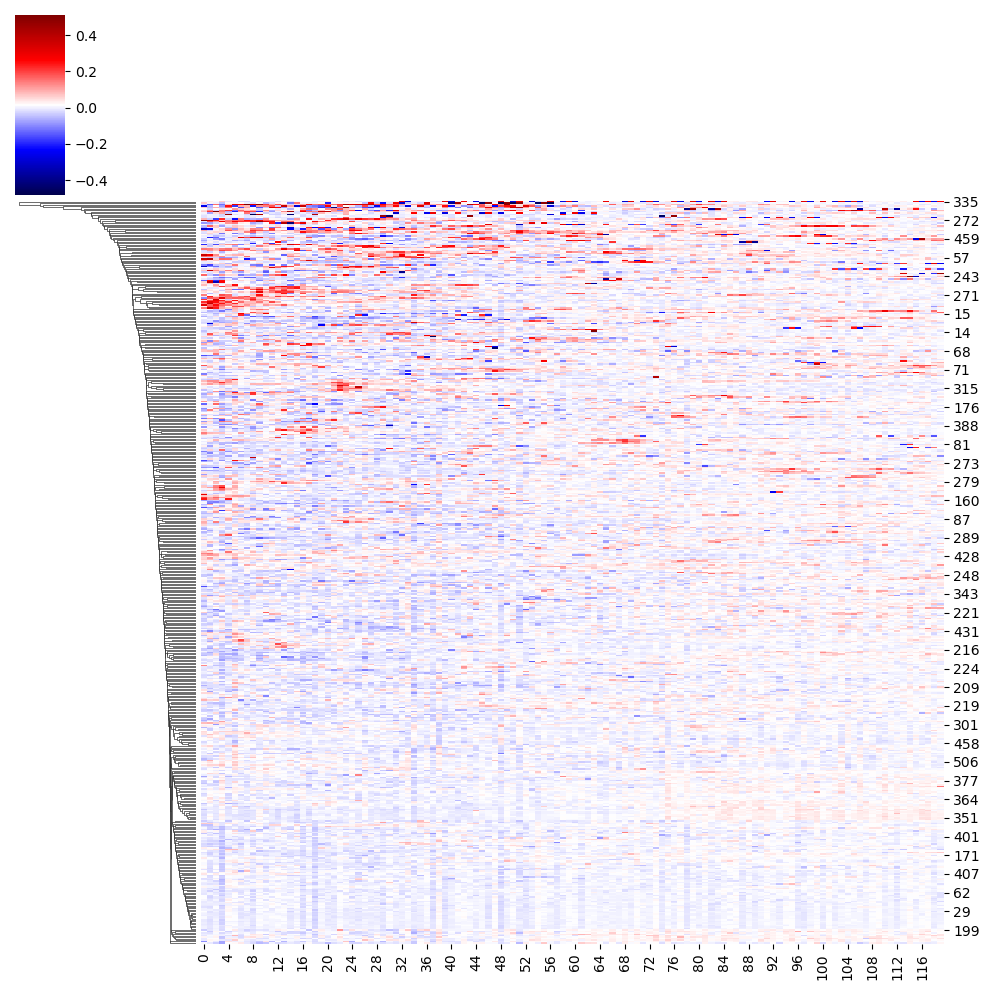

In [37]:
clean_v_matrix = v_matrix[np.logical_not(np.any(np.isnan(v_matrix), axis=1))]
# _, ax = plt.subplots(1, 1, figsize=(4, 8))
g = sns.clustermap(clean_v_matrix, cmap="seismic", row_cluster=True, col_cluster=False)

In [20]:
dist_v_df["distance_cat"] = pd.cut(dist_v_df.distance, 10)
dist_v_df.distance_cat = dist_v_df.distance_cat.apply(lambda x: (x.left + x.right) // 2)

Text(0.5, 1.0, '$0.12\\pm0.08\\;\\mu m/s$')

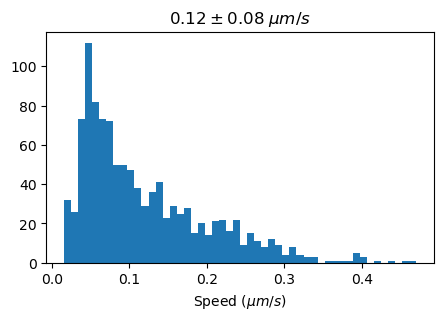

In [22]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(dist_v_df.vmax, bins=50)
ax.set_xlabel("Speed ($\mu m/s$)")
ax.set_title(f"$%.2f\pm%.2f\;\mu m/s$" % (np.mean(dist_v_df.vmax), np.std(dist_v_df.vmax)))

<AxesSubplot: xlabel='distance_cat', ylabel='vmax'>

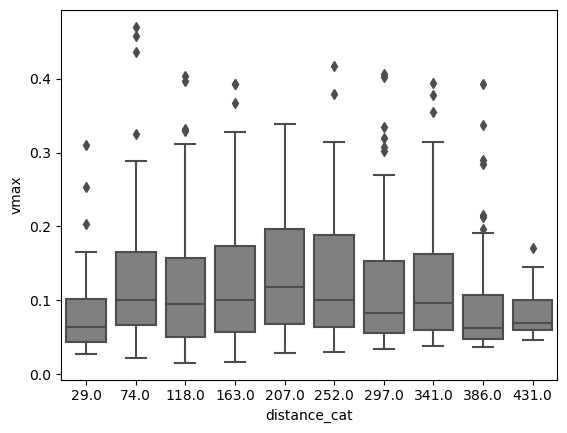

In [23]:
import seaborn as sns

sns.boxplot(data=dist_v_df, x="distance_cat", y="vmax", color="gray")